In [1]:
from __future__ import print_function
from __future__ import division
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64,64,3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 1024)
        self.fc = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512, 10)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm1 = nn.BatchNorm1d(1024)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.batchnorm1(self.fc1(x)))
        x = F.relu(self.batchnorm2(self.fc(x)))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

def eval_net(dataloader):
    correct = 0
    total = 0
    total_loss = 0
    net.eval() # Why would I do this?
    criterion = nn.CrossEntropyLoss(size_average=False)
    for data in dataloader:
        images, labels = data
        images, labels = Variable(images).cuda(), Variable(labels).cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    net.train() # Why would I do this?
    print("number of correct for this epoch is",correct.item())
    return total_loss / total, correct.item() / total


In [4]:
if __name__ == "__main__":
    
    BATCH_SIZE = 32 #mini_batch size
    MAX_EPOCH = 10 #maximum epoch to train

    shape = None

    all_info = {}
    all_info['train']={}
    all_info['test']={}
    all_info['train']['x'] = range(1,MAX_EPOCH+1)
    all_info['test']['x'] = range(1,MAX_EPOCH+1)
    all_info['train']['acc_y'] = []
    all_info['train']['loss_y'] = []
    all_info['test']['acc_y'] = [] 
    all_info['test']['loss_y'] = []
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #torchvision.transforms.Normalize(mean, std)

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    print('Building model...')
    net = Net().cuda()
#     net = Net()
#     net_loaded = torch.load('Q1/Q1_with.pth')
#     model_dict = net.state_dict()
    
#     for key in net_loaded.keys():
#         if key in model_dict:
#             del model_dict[key]
            
    
#     model_dict.update(net_loaded)
    
#     net.load_state_dict(model_dict)
    
#     net.fc2 = nn.Linear(512, 10)
#     net.cuda()
    
    net.train() # Why would I do this?

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.01,betas=(0.9,0.99))
    print('Start training...')
    for epoch in range(MAX_EPOCH):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            shape = [inputs.shape,labels.shape]
            # wrap them in Variable
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:    # print every 2000 mini-batches
                print('    Step: %5d avg_batch_loss: %.5f' %
                      (i + 1, running_loss / 500))
                running_loss = 0.0
        print('    Finish training this EPOCH, start evaluating...')
        train_loss, train_acc = eval_net(trainloader)
        all_info['train']['acc_y'].append(train_acc)
        all_info['train']['loss_y'].append(train_loss)



        test_loss, test_acc = eval_net(testloader)
        all_info['test']['acc_y'].append(test_acc)
        all_info['test']['loss_y'].append(test_loss)
        print("shapes:",shape[0],shape[1])
        print('EPOCH: %d train_loss: %.5f train_acc: %.5f test_loss: %.5f test_acc %.5f' %
              (epoch+1, train_loss, train_acc, test_loss, test_acc))
    print('Finished Training')
    print('Saving model...')

Files already downloaded and verified
Files already downloaded and verified
Building model...
Start training...
    Step:   500 avg_batch_loss: 1.82936
    Step:  1000 avg_batch_loss: 1.45759
    Step:  1500 avg_batch_loss: 1.30103
    Finish training this EPOCH, start evaluating...


/nfs/stak/users/bhattpa/anaconda3/envs/assignment3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


number of correct for this epoch is 29617
number of correct for this epoch is 5758
shapes: torch.Size([16, 3, 32, 32]) torch.Size([16])
EPOCH: 1 train_loss: 1.14681 train_acc: 0.59234 test_loss: 1.19392 test_acc 0.57580
    Step:   500 avg_batch_loss: 1.16033
    Step:  1000 avg_batch_loss: 1.08473
    Step:  1500 avg_batch_loss: 1.03895
    Finish training this EPOCH, start evaluating...
number of correct for this epoch is 31800
number of correct for this epoch is 6181
shapes: torch.Size([16, 3, 32, 32]) torch.Size([16])
EPOCH: 2 train_loss: 1.00529 train_acc: 0.63600 test_loss: 1.07255 test_acc 0.61810
    Step:   500 avg_batch_loss: 0.91624
    Step:  1000 avg_batch_loss: 0.91800
    Step:  1500 avg_batch_loss: 0.89138
    Finish training this EPOCH, start evaluating...
number of correct for this epoch is 37336
number of correct for this epoch is 6944
shapes: torch.Size([16, 3, 32, 32]) torch.Size([16])
EPOCH: 3 train_loss: 0.71640 train_acc: 0.74672 test_loss: 0.86399 test_acc 0.69

In [5]:
torch.save(net.state_dict(), 'Q4/Q4b.pth')

In [13]:
pd.DataFrame({
        'epochs':all_info['train']['x'],
        'Train Accuracy':all_info['train']['acc_y'],
        'Test Accuracy':all_info['test']['acc_y'],
        'Train Loss':all_info['train']['loss_y'],
        'Test Loss':all_info['test']['loss_y']
        }).to_csv("Q4/Q4b.csv",index=False)


In [18]:
data = pd.read_csv('Q4/Q4a.csv')

In [15]:
data.head(29)

,epochs,Train Accuracy,Test Accuracy,Train Loss,Test Loss
0,1,0.59234,0.5758,1.146814,1.193919
1,2,0.63600,0.6181,1.005286,1.072546
2,3,0.74672,0.6944,0.716404,0.863987
3,4,0.75504,0.6879,0.683778,0.898638
4,5,0.80400,0.7115,0.564552,0.855377
5,6,0.86534,0.7401,0.398808,0.774903
6,7,0.89260,0.7390,0.311381,0.812088
7,8,0.90402,0.7339,0.280833,0.848266
8,9,0.94604,0.7449,0.168613,0.864243
9,10,0.95988,0.7529,0.130826,0.888371


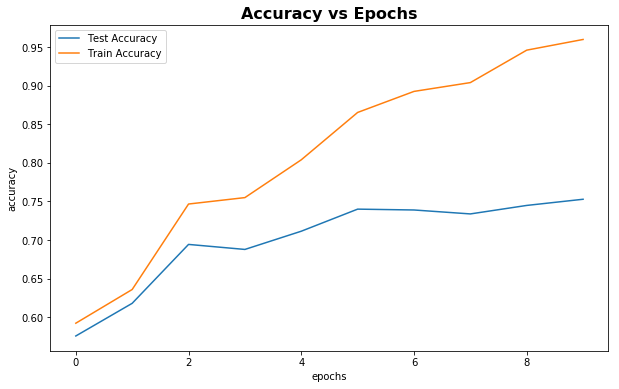

In [9]:
plt.figure(figsize=(10,6))
plt.plot(data['Test Accuracy'],label="Test Accuracy")
plt.plot(data['Train Accuracy'],label='Train Accuracy')
plt.title("Accuracy vs Epochs",fontweight='bold',fontsize=16)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')

#plt.show()
plt.savefig('Q4/Q4b_1.png')

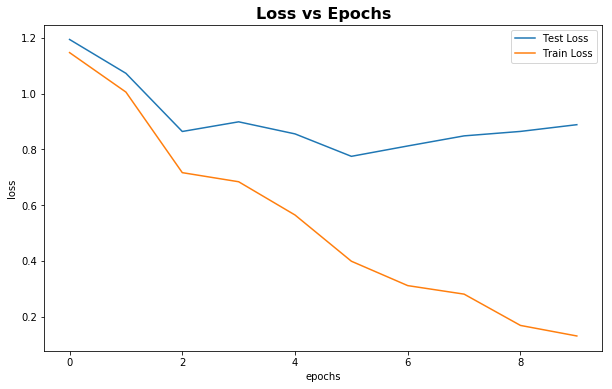

In [10]:
plt.figure(figsize=(10,6))
plt.plot(data['Test Loss'],label='Test Loss')
plt.plot(data['Train Loss'],label='Train Loss')
plt.title("Loss vs Epochs",fontweight='bold',fontsize=16)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
#plt.show()
plt.savefig('Q4/Q4b_2.png')

In [19]:
data['Train Accuracy'].max()

0.9393600000000001

In [20]:
data['Test Accuracy'].max()

0.7448

In [27]:
data = pd.read_csv('Q4/Q4b.csv')
print(data['Train Accuracy'].max())
print(data['Test Accuracy'].max())

0.95988
0.7529
